We will be using the starter dataset on kaggle available (https://www.kaggle.com/c/titanic/data)


### Importing libraries

In [74]:
#Importing the basic libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

### Reading data

In [75]:
### Importing data 
train = pd.read_csv('../data/titanic/train.csv')
test = pd.read_csv('../data/titanic/test.csv')
ty = pd.read_csv('../data/titanic/gender_submission.csv')
## Merging the surivived col to test df
test = pd.merge(test, ty, on='PassengerId')
## Merging train and test df
df = pd.concat([train, test], sort=True)

Convert name to titles

In [76]:
# for name in df['Name'].values:
#     print(name.split(', ')[1].split(' ')[0])

    
# Cleaning name and extracting Title
# for name_string in df['Name']:
df['Salutation'] = df['Name'].str.extract(r'([A-Za-z]+)\.')

# df['Name'].str.extract(r'([A-Za-z]+)\.')[0].value_counts()

replacements = {'Rev': 'Spec', 'Dr': 'Spec', 'Col':'Spec', 'Ms': 'Miss', 'Mlle': 'Spec', 'Major': 'Spec',
               'Dona': 'Spec','Sir': 'Spec', 'Lady': 'Spec','Jonkheer': 'Spec', 'Countess': 'Spec',
                'Don': 'Spec','Capt': 'Spec',
                'Mme': 'Spec'}

df.replace({'Salutation': replacements}, inplace=True)

In [77]:
df['Salutation'].value_counts()

Mr        757
Miss      262
Mrs       197
Master     61
Spec       32
Name: Salutation, dtype: int64

In [78]:
## Selecting limited cols from the dataframe
df
df = df[['Salutation', 'Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived']]

Just to get a basic idea of the correlation between various parameters we plot a coorelation using heatmap of seaborn library

Text(0.5, 1.0, 'Correlation plot')

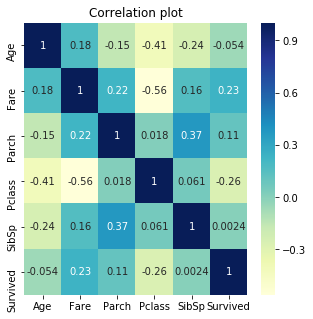

In [79]:
corr=df.corr()
plt.figure(figsize=(5,5))

sns.heatmap(corr, cmap='YlGnBu', annot=True)

plt.title('Correlation plot')

#### Checking how may rows have null values

In [80]:
df.isnull().sum()

Salutation      0
Age           263
Embarked        2
Fare            1
Parch           0
Pclass          0
Sex             0
SibSp           0
Survived        0
dtype: int64

We can see that age has the most missing values, but we cannot remove these rows as we will loose a significant amount of data, so we initially just put the mean of the age

In [81]:
# Replacing na with mean age
df['Age'].fillna(df['Age'].mean(), inplace=True)
# a better approach for filling na would be to create another model which can predict the age based on 
# other parameters

In [82]:
# Removing the embarked and fare rows which have value NA
df.dropna(inplace=True)

Now that we have removed all the missing values, we can confirm it and convert our categorical data to numeric data

In [83]:
df.isnull().sum()

Salutation    0
Age           0
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived      0
dtype: int64

First we check how many categories are there in columns Sex and Embarked

In [84]:
print(df['Sex'].value_counts())
print(df['Embarked'].value_counts())

male      842
female    464
Name: Sex, dtype: int64
S    913
C    270
Q    123
Name: Embarked, dtype: int64


Converting the categorical values like male, female to numeric values for our model

In [85]:
# Mr        756
# Miss      261
# Mrs       196
# Master     61
# Spec       32

In [89]:
cols = {'Sex': {'male':0, 'female': 1}, 'Embarked': {'S':1, 'C':2,'Q':3},
       'Salutation': {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Spec':5 } }
df.replace(cols, inplace=True)

We then convert our dataset into train and test set using a 80/20 split

In [97]:
X = df[['Salutation', 'Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']]
y = df[['Survived']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1044, 8) (1044,)
Test set: (262, 8) (262,)


Now that all our data has been cleaned and split into test and train variables we will use multiple models to check which one achieves the most accuracy

In [98]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, y_train)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
scores = cross_val_score(clf, X, y, scoring='f1', cv=6)
print ('Cross-validated scores:', scores.mean())

Cross-validated scores: 0.7930207505664079


Using random forest classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
scores = cross_val_score(clf, X, y, scoring='f1', cv=6)
print ('Cross-validated scores:', scores.mean())

Cross-validated scores: 0.7660512911183653


We can check which features are more important than the others in random forest

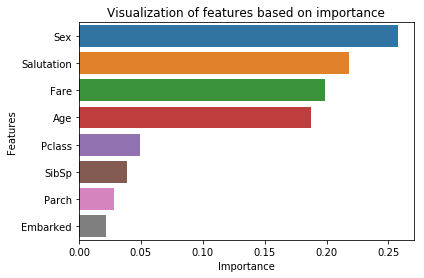

In [103]:
imp_features = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

sns.barplot(x=imp_features, y=imp_features.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Visualization of features based on importance')
plt.show()

As we can see the 3 most important features are sex, fare, and age.